## Dependencias 

In [147]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns 

from dateutil.relativedelta import relativedelta as rd
from datetime import date 
from CreditScoringToolkit.frequency_table import frequency_table
from CreditScoringToolkit.DiscreteNormalizer import DiscreteNormalizer

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler,StandardScaler


from varclushi import VarClusHi
from scipy import stats 

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format',lambda x: '%.2f' % x)

## Variables relevantes

In [64]:
um = ['id']
varc = ['acc_now_delinq',
'acc_open_past_24mths',
'annual_inc',
'bc_open_to_buy',
'bc_util',
'dti',
'fico_range_high',
'il_util',
'inq_last_12m',
'inq_last_6mths',
'loan_amnt',
'max_bal_bc',
'mths_since_last_delinq',
'num_accts_ever_120_pd',
'open_acc_6m',
'total_rev_hi_lim']

vard = ['addr_state',
'emp_length',
'emp_title',
'grade',
'home_ownership','application_type','term']

varf = ['earliest_cr_line','issue_d']

vart = ['loan_status']


## Lectura de datos

In [65]:
df = pd.read_csv('../data/lending_club.csv',dtype=str,usecols=um+varc+vard+varf+vart)

## Limpieza de los datos 

In [66]:
df = df.loc[df['application_type']=='Individual'].reset_index(drop=True)

In [67]:
for v in varc:
    df[v] = pd.to_numeric(df[v],errors='coerce')

In [68]:
for v in vard:
    df[v] = df[v].fillna('MISSING')

In [69]:
df[vart[0]] = np.where(df[vart[0]].isin(['Current','Fully Paid']),0,1)

In [70]:
for v in varf:
    df[v] = pd.to_datetime(df[v],format='%b-%Y',errors='coerce')
    df = df.loc[df[v].notnull()].reset_index(drop=True)

In [71]:
df['tob'] = np.vectorize(rd)(df['issue_d'].dt.date, df['earliest_cr_line'].dt.date)
df['tob'] = df['tob'].map(lambda x:x.years*12+x.months)

In [72]:
varc.append('tob')

In [73]:
df.head()

,id,loan_amnt,term,grade,emp_title,emp_length,home_ownership,annual_inc,issue_d,loan_status,addr_state,dti,earliest_cr_line,fico_range_high,inq_last_6mths,mths_since_last_delinq,application_type,acc_now_delinq,open_acc_6m,il_util,max_bal_bc,total_rev_hi_lim,inq_last_12m,acc_open_past_24mths,bc_open_to_buy,bc_util,num_accts_ever_120_pd,tob
0,68407277,3600.0,36 months,C,leadman,10+ years,MORTGAGE,55000.0,2015-12-01,0,PA,5.91,2003-08-01,679.0,1.0,30.0,Individual,0.0,2.0,36.0,722.0,9300.0,4.0,4.0,1506.0,37.2,2.0,148
1,68355089,24700.0,36 months,C,Engineer,10+ years,MORTGAGE,65000.0,2015-12-01,0,SD,16.06,1999-12-01,719.0,4.0,6.0,Individual,0.0,1.0,73.0,6472.0,111800.0,6.0,4.0,57830.0,27.1,0.0,192
2,66310712,35000.0,60 months,C,Information Systems Officer,10+ years,MORTGAGE,110000.0,2015-12-01,0,NJ,17.06,2008-09-01,789.0,0.0,NaN,Individual,0.0,1.0,70.0,6987.0,67300.0,0.0,2.0,54962.0,12.1,0.0,87
3,68476807,10400.0,60 months,F,Contract Specialist,3 years,MORTGAGE,104433.0,2015-12-01,0,PA,25.37,1998-06-01,699.0,3.0,12.0,Individual,0.0,1.0,84.0,9702.0,34000.0,3.0,10.0,4567.0,77.5,0.0,210
4,68426831,11950.0,36 months,C,Veterinary Tecnician,4 years,RENT,34000.0,2015-12-01,0,GA,10.20,1987-10-01,694.0,0.0,NaN,Individual,0.0,0.0,99.0,4522.0,12900.0,0.0,0.0,844.0,91.0,0.0,338


In [74]:
df = df.loc[df['issue_d']>=pd.to_datetime('2015-05-01')].reset_index(drop=True)

In [75]:
df['emp_title'] = df['emp_title'].str.lower().map(lambda x: "_".join((x.split(' '))))

In [76]:
df.drop('earliest_cr_line',axis=1,inplace=True)
varf.remove('earliest_cr_line')

In [77]:
df.head(5)

,id,loan_amnt,term,grade,emp_title,emp_length,home_ownership,annual_inc,issue_d,loan_status,addr_state,dti,fico_range_high,inq_last_6mths,mths_since_last_delinq,application_type,acc_now_delinq,open_acc_6m,il_util,max_bal_bc,total_rev_hi_lim,inq_last_12m,acc_open_past_24mths,bc_open_to_buy,bc_util,num_accts_ever_120_pd,tob
0,68407277,3600.0,36 months,C,leadman,10+ years,MORTGAGE,55000.0,2015-12-01,0,PA,5.91,679.0,1.0,30.0,Individual,0.0,2.0,36.0,722.0,9300.0,4.0,4.0,1506.0,37.2,2.0,148
1,68355089,24700.0,36 months,C,engineer,10+ years,MORTGAGE,65000.0,2015-12-01,0,SD,16.06,719.0,4.0,6.0,Individual,0.0,1.0,73.0,6472.0,111800.0,6.0,4.0,57830.0,27.1,0.0,192
2,66310712,35000.0,60 months,C,information_systems_officer,10+ years,MORTGAGE,110000.0,2015-12-01,0,NJ,17.06,789.0,0.0,NaN,Individual,0.0,1.0,70.0,6987.0,67300.0,0.0,2.0,54962.0,12.1,0.0,87
3,68476807,10400.0,60 months,F,contract_specialist,3 years,MORTGAGE,104433.0,2015-12-01,0,PA,25.37,699.0,3.0,12.0,Individual,0.0,1.0,84.0,9702.0,34000.0,3.0,10.0,4567.0,77.5,0.0,210
4,68426831,11950.0,36 months,C,veterinary_tecnician,4 years,RENT,34000.0,2015-12-01,0,GA,10.20,694.0,0.0,NaN,Individual,0.0,0.0,99.0,4522.0,12900.0,0.0,0.0,844.0,91.0,0.0,338


In [88]:
df.to_csv('../data/lending_club_clean.csv',index=False)

## Partición 

In [127]:
train,valid = train_test_split(df,test_size=0.3,random_state=0)
train = train.sample(10000,random_state=0).reset_index(drop=True)
train.reset_index(drop=True,inplace=True)
valid.reset_index(drop=True,inplace=True)
train.shape,valid.shape

((10000, 27), (466173, 27))

## Análisis Exploratorio de Datos 

### Continuo 

#### Ausentes

In [128]:
miss = (train[varc].isnull().sum())/len(train)
miss = miss.sort_values(ascending=False).to_frame('missing')
miss

,missing
inq_last_12m,0.18
max_bal_bc,0.18
open_acc_6m,0.18
bc_util,0.01
bc_open_to_buy,0.01
acc_now_delinq,0.00
acc_open_past_24mths,0.00
annual_inc,0.00
dti,0.00
fico_range_high,0.00


In [129]:
im = SimpleImputer(strategy='median')
im.fit(train[varc])
Xi = pd.DataFrame(im.transform(train[varc]),columns=varc)

In [130]:
ks = [(v,stats.ks_2samp(Xi[v],train[v].dropna()).statistic) for v in varc]
ks = pd.DataFrame(ks,columns=['variable','ks']).set_index('variable')
ks.sort_values('ks',ascending=False)

,ks
variable,
max_bal_bc,0.09
inq_last_12m,0.08
open_acc_6m,0.08
bc_util,0.00
bc_open_to_buy,0.00
acc_now_delinq,0.00
acc_open_past_24mths,0.00
annual_inc,0.00
dti,0.00


In [131]:
fuera = list(ks.loc[ks['ks']>0.1].index)
fuera

[]

In [132]:
varc = [v for v in varc if v not in fuera]

#### Multicolinealidad 

In [133]:
vc = VarClusHi(Xi[varc].sample(3000),feat_list=varc).varclus()
mc = list(vc.rsquare.sort_values(by=['Cluster','RS_Ratio'],ascending=[True,True]).groupby('Cluster').first()['Variable'])
mc

['annual_inc',
 'open_acc_6m',
 'bc_util',
 'acc_now_delinq',
 'num_accts_ever_120_pd',
 'dti']

#### Extremos 

array([[<Axes: title={'center': 'annual_inc'}>,
        <Axes: title={'center': 'open_acc_6m'}>],
       [<Axes: title={'center': 'bc_util'}>,
        <Axes: title={'center': 'acc_now_delinq'}>],
       [<Axes: title={'center': 'num_accts_ever_120_pd'}>,
        <Axes: title={'center': 'dti'}>]], dtype=object)

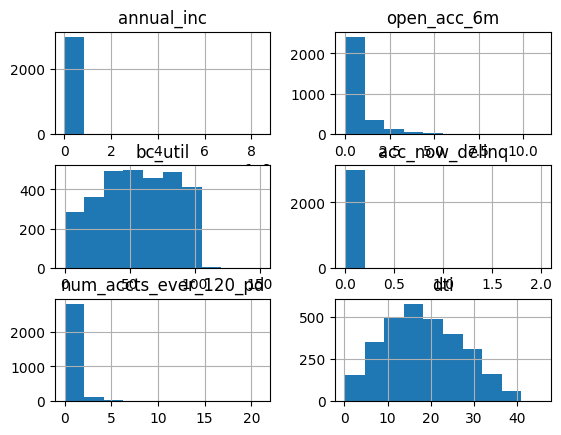

In [134]:
Xi[mc].sample(3000).hist()

In [135]:
for v,li,ls in Xi[mc].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    Xi[f'ex_{v}'] = ((Xi[v]<li)|(Xi[v]>ls)).astype(int)
Xi['ex_'] = Xi.filter(like='ex_').max(axis=1)
frequency_table(Xi,['ex_'])

****Frequency Table  ex_  ***


     Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  Cumm. Rel. Freq.
ex_                                                            
0          9345        0.93              9345              0.93
1           655        0.07             10000              1.00






In [136]:
Xi[um] = train[um]

In [137]:
Xi = Xi.loc[Xi['ex_']==0].reset_index(drop=True)
Xi.drop(Xi.filter(like='ex_').columns,axis=1,inplace=True)

In [138]:
Xi.head()

,acc_now_delinq,acc_open_past_24mths,annual_inc,bc_open_to_buy,bc_util,dti,fico_range_high,inq_last_12m,inq_last_6mths,loan_amnt,max_bal_bc,num_accts_ever_120_pd,open_acc_6m,total_rev_hi_lim,tob,id
0,0.00,6.00,65000.00,4033.00,46.20,15.07,674.00,2.00,1.00,10000.00,2393.00,0.00,2.00,8600.00,195.00,144229429
1,0.00,7.00,36000.00,1018.00,82.40,27.97,669.00,0.00,0.00,15000.00,2225.00,0.00,0.00,21400.00,163.00,144141077
2,0.00,4.00,75000.00,20924.00,1.80,5.84,684.00,4.00,0.00,5500.00,347.00,0.00,2.00,27200.00,247.00,142059156
3,0.00,3.00,50000.00,5868.00,69.40,10.15,714.00,1.00,0.00,15500.00,5071.00,0.00,1.00,24600.00,148.00,78588271
4,0.00,5.00,55000.00,5310.00,21.90,18.55,704.00,1.00,1.00,25000.00,4281.00,0.00,1.00,36300.00,98.00,46747583


array([[<Axes: title={'center': 'annual_inc'}>,
        <Axes: title={'center': 'open_acc_6m'}>],
       [<Axes: title={'center': 'bc_util'}>,
        <Axes: title={'center': 'acc_now_delinq'}>],
       [<Axes: title={'center': 'num_accts_ever_120_pd'}>,
        <Axes: title={'center': 'dti'}>]], dtype=object)

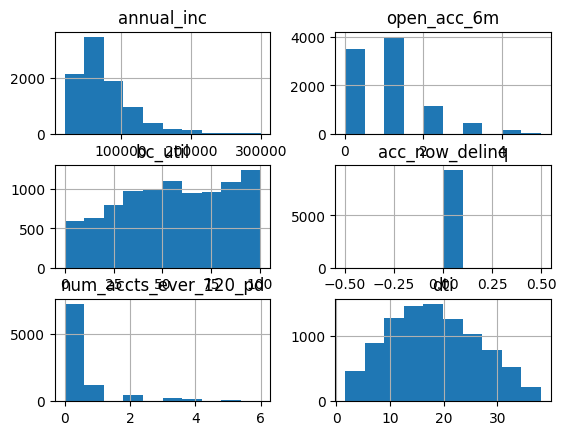

In [139]:
Xi[mc].hist()

### Discreto

In [140]:
Xd = train[vard+um].copy()

In [141]:
dn = DiscreteNormalizer(normalization_threshold=0.05)
dn.fit(Xd[vard])

/Users/josegustavofuentescabrera/Documents/anahuac/aprendizaje_supervisado/.venv/lib/python3.11/site-packages/CreditScoringToolkit/DiscreteNormalizer.py:73: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  aux['mapping'].replace({default_category:mode},inplace=True)
/Users/josegustavofuentescabrera/Documents/anahuac/aprendizaje_supervisado/.venv/lib/python3.11/site-packages/CreditScoringToolkit/DiscreteNormalizer.py:73: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using 

In [142]:
Xd[vard] = dn.transform(Xd[vard])

/Users/josegustavofuentescabrera/Documents/anahuac/aprendizaje_supervisado/.venv/lib/python3.11/site-packages/CreditScoringToolkit/DiscreteNormalizer.py:114: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  aux[feat].replace(mapping,inplace=True)
/Users/josegustavofuentescabrera/Documents/anahuac/aprendizaje_supervisado/.venv/lib/python3.11/site-packages/CreditScoringToolkit/DiscreteNormalizer.py:114: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.


In [143]:
frequency_table(Xd,vard)

****Frequency Table  addr_state  ***


            Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  Cumm. Rel. Freq.
addr_state                                                            
CA                1376        0.14              1376              0.14
FL                 698        0.07              2074              0.21
NY                 878        0.09              2952              0.30
OTHER             6213        0.62              9165              0.92
TX                 835        0.08             10000              1.00




****Frequency Table  emp_length  ***


            Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  Cumm. Rel. Freq.
emp_length                                                            
1 year             675        0.07               675              0.07
10+ years         3348        0.33              4023              0.40
2 years            927        0.09              4950              0.49
3 years            843        0.08              5793              

In [146]:
unary = [v for v in vard if Xd[v].nunique()==1]
unary

[]

In [145]:
vard = [v for v in vard if v not in unary]
dn.fit(Xd[vard])
Xd[vard] = dn.transform(Xd[vard])

/Users/josegustavofuentescabrera/Documents/anahuac/aprendizaje_supervisado/.venv/lib/python3.11/site-packages/CreditScoringToolkit/DiscreteNormalizer.py:73: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  aux['mapping'].replace({default_category:mode},inplace=True)
/Users/josegustavofuentescabrera/Documents/anahuac/aprendizaje_supervisado/.venv/lib/python3.11/site-packages/CreditScoringToolkit/DiscreteNormalizer.py:73: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using 

In [ ]:
oh = OneHotEncoder(drop='if_binary',sparse_output=False)
oh.fit(Xd[vard])
varoh = list(oh.get_feature_names_out())

In [150]:
Xd[varoh] = oh.transform(Xd[vard])

In [152]:
Xd[um] = train[um]

## Consolidar Datos (TAD: Tabla Analítica de Datos)

In [163]:
tad = Xi.merge(Xd[um+varoh],on=um,how='inner').merge(train[vart+um],on=um,how='inner')[um+vart+mc+varoh]
tad.shape

(9345, 32)

In [164]:
tad.sample(5)

,id,loan_status,annual_inc,open_acc_6m,bc_util,acc_now_delinq,num_accts_ever_120_pd,dti,addr_state_CA,addr_state_FL,addr_state_NY,addr_state_OTHER,addr_state_TX,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_< 1 year,emp_length_MISSING,emp_length_OTHER,emp_title_missing,grade_A,grade_B,grade_C,grade_D,grade_E,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,term_ 60 months
2306,107364033,0,40000.00,1.00,10.50,0.00,0.00,3.36,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
7677,67015225,1,60000.00,0.00,0.00,0.00,0.00,10.30,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00
4896,137272098,0,36000.00,1.00,25.00,0.00,0.00,19.07,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1904,88145995,0,120000.00,1.00,1.30,0.00,3.00,13.45,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
1422,115718817,0,126376.00,1.00,72.70,0.00,0.00,25.88,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00


## Espacios

### Vector respuesta $\vec{y}$

In [ ]:
y = tad[um+vart].copy()

### Espacio Original $\mathcal{X}$

In [ ]:
X = tad[um+mc+varoh].copy()


### Espacio híper-caja $\mathcal{X}_{[0,1]}$

In [167]:
sc01 = MinMaxScaler()
sc01.fit(X[mc+varoh])
X01 = pd.DataFrame(sc01.transform(X[mc+varoh]),columns=mc+varoh)
X01[um] = X[um]
X01.head()

,annual_inc,open_acc_6m,bc_util,acc_now_delinq,num_accts_ever_120_pd,dti,addr_state_CA,addr_state_FL,addr_state_NY,addr_state_OTHER,addr_state_TX,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_< 1 year,emp_length_MISSING,emp_length_OTHER,emp_title_missing,grade_A,grade_B,grade_C,grade_D,grade_E,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,term_ 60 months,id
0,0.16,0.40,0.46,0.00,0.00,0.37,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,144229429
1,0.06,0.00,0.82,0.00,0.00,0.72,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,144141077
2,0.20,0.40,0.02,0.00,0.00,0.12,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,142059156
3,0.11,0.20,0.69,0.00,0.00,0.23,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,78588271
4,0.13,0.20,0.22,0.00,0.00,0.46,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,46747583


### Espacio estandarizado $\mathcal{X}_{\mu=0,\sigma=1}$

In [169]:
sc = StandardScaler()
sc.fit(X[mc+varoh])
Xs = pd.DataFrame(sc.transform(X[mc+varoh]),columns=mc+varoh)
Xs[um]  = X[um]
Xs.describe()

,annual_inc,open_acc_6m,bc_util,acc_now_delinq,num_accts_ever_120_pd,dti,addr_state_CA,addr_state_FL,addr_state_NY,addr_state_OTHER,addr_state_TX,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_< 1 year,emp_length_MISSING,emp_length_OTHER,emp_title_missing,grade_A,grade_B,grade_C,grade_D,grade_E,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,term_ 60 months
count,9345.00,9345.00,9345.00,9345.00,9345.00,9345.00,9345.00,9345.00,9345.00,9345.00,9345.00,9345.00,9345.00,9345.00,9345.00,9345.00,9345.00,9345.00,9345.00,9345.00,9345.00,9345.00,9345.00,9345.00,9345.00,9345.00,9345.00,9345.00,9345.00,9345.00
mean,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00
std,1.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.38,-0.95,-1.99,0.00,-0.43,-2.01,-0.40,-0.27,-0.31,-1.28,-0.30,-0.27,-0.71,-0.32,-0.30,-0.25,-0.25,-0.29,-0.26,-0.43,-0.27,-0.51,-0.68,-0.64,-0.39,-0.24,-0.94,-0.37,-0.83,-0.62
25%,-0.66,-0.95,-0.79,0.00,-0.43,-0.77,-0.40,-0.27,-0.31,-1.28,-0.30,-0.27,-0.71,-0.32,-0.30,-0.25,-0.25,-0.29,-0.26,-0.43,-0.27,-0.51,-0.68,-0.64,-0.39,-0.24,-0.94,-0.37,-0.83,-0.62
50%,-0.25,0.07,0.02,0.00,-0.43,-0.06,-0.40,-0.27,-0.31,0.78,-0.30,-0.27,-0.71,-0.32,-0.30,-0.25,-0.25,-0.29,-0.26,-0.43,-0.27,-0.51,-0.68,-0.64,-0.39,-0.24,-0.94,-0.37,-0.83,-0.62
75%,0.41,0.07,0.88,0.00,-0.43,0.73,-0.40,-0.27,-0.31,0.78,-0.30,-0.27,1.40,-0.32,-0.30,-0.25,-0.25,-0.29,-0.26,-0.43,-0.27,-0.51,1.47,1.56,-0.39,-0.24,1.06,-0.37,1.21,1.61
max,5.23,4.18,1.60,0.00,5.66,2.42,2.49,3.68,3.23,0.78,3.29,3.74,1.40,3.12,3.29,3.92,3.95,3.47,3.89,2.31,3.67,1.95,1.47,1.56,2.58,4.21,1.06,2.69,1.21,1.61


In [176]:
from tpot import TPOTClassifier

/Users/josegustavofuentescabrera/Documents/anahuac/aprendizaje_supervisado/.venv/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [177]:
pipeline_optimizer = TPOTClassifier(generations=5, population_size=20, cv=5,
                                    random_state=42, verbosity=2)
pipeline_optimizer.fit(X[mc+varoh], y[vart[0]])

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8784376672017121

Generation 2 - Current best internal CV score: 0.8784376672017121

Generation 3 - Current best internal CV score: 0.8784376672017121

Generation 4 - Current best internal CV score: 0.8784376672017121

Generation 5 - Current best internal CV score: 0.8786516853932586

Best pipeline: RandomForestClassifier(input_matrix, bootstrap=True, criterion=entropy, max_features=0.8, min_samples_leaf=8, min_samples_split=4, n_estimators=100)


TPOTClassifier(generations=5, population_size=20, random_state=42, verbosity=2)

In [178]:
pipeline_optimizer.export('tpot_exported_pipeline.py')